## Imports

In [1]:
# Loading data and viz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing and preprocessing
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

# Data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Loading the data

In [2]:
data = pd.read_csv('dataset.csv', sep=';')
data = data.drop_duplicates()
data = data.drop(columns=['uuid'])
data.columns

Index(['default', 'account_amount_added_12_24m', 'account_days_in_dc_12_24m',
       'account_days_in_rem_12_24m', 'account_days_in_term_12_24m',
       'account_incoming_debt_vs_paid_0_24m', 'account_status',
       'account_worst_status_0_3m', 'account_worst_status_12_24m',
       'account_worst_status_3_6m', 'account_worst_status_6_12m', 'age',
       'avg_payment_span_0_12m', 'avg_payment_span_0_3m', 'merchant_category',
       'merchant_group', 'has_paid', 'max_paid_inv_0_12m',
       'max_paid_inv_0_24m', 'name_in_email',
       'num_active_div_by_paid_inv_0_12m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m',
       'num_arch_ok_12_24m', 'num_arch_rem_0_12m',
       'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m',
       'num_unpaid_bills', 'status_last_archived_0_24m',
       'status_2nd_last_archived_0_24m', 'status_3rd_last_archived_0_24m',
       'status_max_archived_0_6_months', 'status_max_archived_0_12_months',
       

## A quick look at the data

The most important aspect so far is to check whether we want to a good precision or a good recall 
(i.e. limit the false positives or the false negatives). Here, I would argue it is best to catch all
potential failing companies even if it means that we will maybe have a few false positives. In this case,
we want to maximise our *precision*

### Basic info

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99976 entries, 0 to 99975
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   default                              89976 non-null  float64
 1   account_amount_added_12_24m          99976 non-null  int64  
 2   account_days_in_dc_12_24m            88140 non-null  float64
 3   account_days_in_rem_12_24m           88140 non-null  float64
 4   account_days_in_term_12_24m          88140 non-null  float64
 5   account_incoming_debt_vs_paid_0_24m  40661 non-null  float64
 6   account_status                       45603 non-null  float64
 7   account_worst_status_0_3m            45603 non-null  float64
 8   account_worst_status_12_24m          33215 non-null  float64
 9   account_worst_status_3_6m            42274 non-null  float64
 10  account_worst_status_6_12m           39626 non-null  float64
 11  age                         

Our $X$ is all the columns from 2 to 42, while our $y$ is the column 1 (`default`). Let's check 
how many of these values are missing out for `default` (from a first look, 10 000)

In [37]:
is_test = data['default'].isna()
data_train, data_test = data[~is_test], data[is_test]
X_train, y_train = data_train.drop(columns=['default']), data_train['default']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
X_test = data_test.drop(columns=['default']) # There is y_test ... !
print(f'Test dataset size {len(X_test)}, train dataset size {len(X_train)}')

Test dataset size 10000, train dataset size 71980


### What to do with the missing values ?

Let's check the columns having the most "voids" and see if the lack of information
can be replaced with something sensible or if they should be discarded. Some of
the data _could_ be missing because the age of the data points are not old enough.

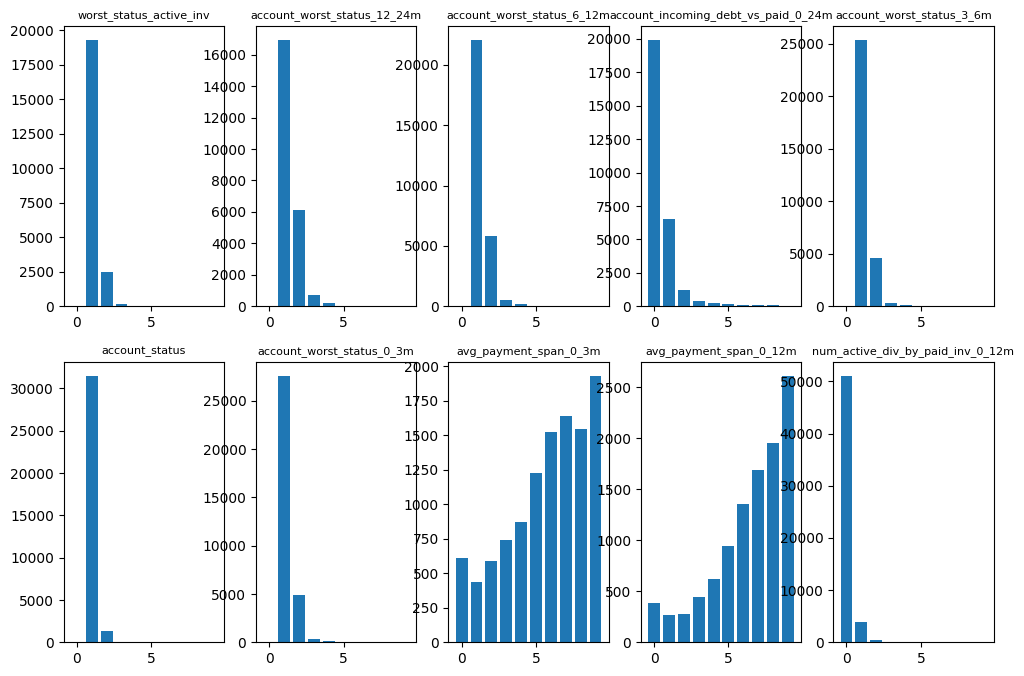

In [38]:
columns_by_na = X_train.isna().sum(axis=0).sort_values(ascending=False).index
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=[12,8])

for col, ax in zip(columns_by_na[:10], axes.ravel()):
    counts, bins = np.histogram(X_train[col], bins=np.arange(-0.5,10.5))
    ax.bar(bins[1:]-0.5, counts)
    ax.set_title(col, fontsize=8)

In [39]:
X_train.age.value_counts()
# Actually, all the data points are old enough (in months) to have all their
# columns filled. So let's assume that the missing columns are the median value
# of the column

18     2677
22     2500
21     2492
23     2343
20     2314
       ... 
91        2
100       1
90        1
92        1
95        1
Name: age, Length: 78, dtype: int64

### Categorical data : listing the categories

In [40]:
X_train.merchant_category.value_counts()

Diversified entertainment                                  27818
Youthful Shoes & Clothing                                   8413
Books & Magazines                                           6786
General Shoes & Clothing                                    3320
Concept stores & Miscellaneous                              3184
Sports gear & Outdoor                                       2712
Dietary supplements                                         2180
Diversified children products                               2169
Diversified electronics                                     1309
Prints & Photos                                             1191
Children Clothes & Nurturing products                       1076
Pet supplies                                                 951
Electronic equipment & Related accessories                   765
Hobby articles                                               670
Jewelry & Watches                                            655
Prescription optics      

In [41]:
X_train.merchant_group.value_counts()

Entertainment             35168
Clothing & Shoes          12002
Leisure, Sport & Hobby     7996
Health & Beauty            5216
Children Products          3698
Home & Garden              2670
Electronics                2174
Intangible products         810
Jewelry & Accessories       760
Automotive Products         687
Erotic Materials            535
Food & Beverage             264
Name: merchant_group, dtype: int64

### Feature Selection ?

One of the column names `has_paid` has a fishy name, that could be a proxy
for the negative of `default`. Let's just check if they are equivalent by
cross-correlating them.

In [42]:
np.corrcoef(X_train.has_paid, y_train)

array([[ 1.        , -0.03375414],
       [-0.03375414,  1.        ]])

They are not completely correlated, so let's consider that the data is valid.
Regarding the other columns, we can check using the pandas method `.corr()`

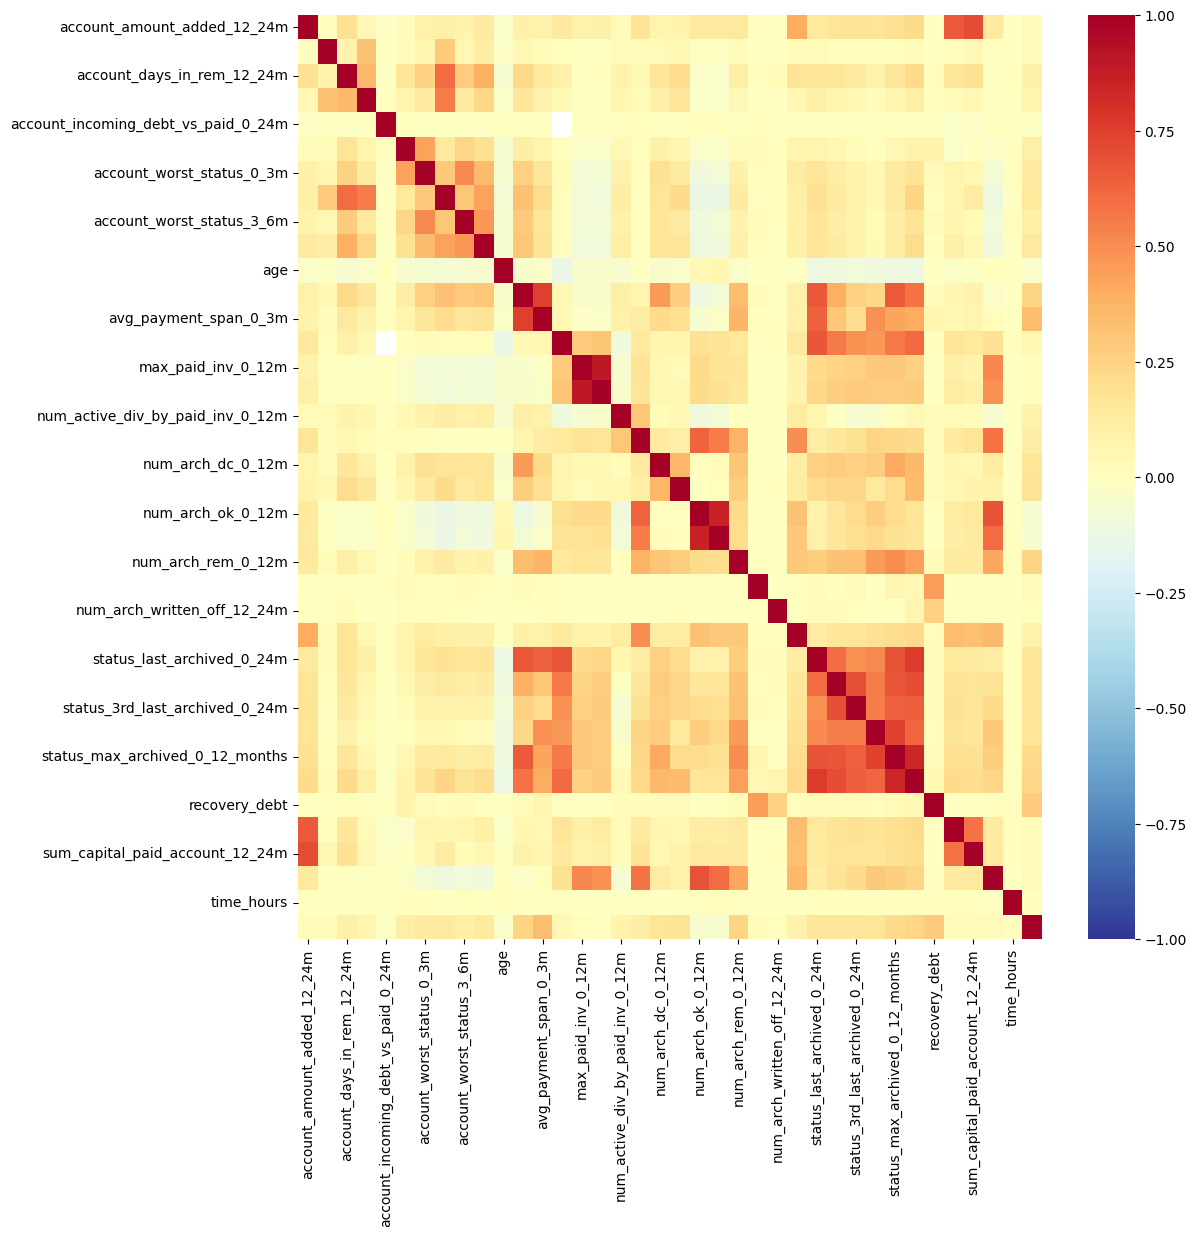

In [43]:
ax = sns.heatmap(X_train.corr(),
                 cmap='RdYlBu_r',
                 vmin=-1,
                 vmax=1)
ax.get_figure().set_size_inches(w=12, h=12)

Some features are indeed correlated (usually things over 12-24 months and the same thing
over 6-12 months, or the amount added in an account and the capital paid on an account) but nothing
_strictly_ correlated that would throw off our fit.

## Pre-processing : building the pipeline

Let's `RobustScale` the numerical data since they don't look very Gaussian 
and impute the median value when it does not exist. We will impute values
using the median value when we encounter NaNs.

Meanwhile, let's One Hot
Encode the categorical values and limit the number of columns, and put the
least frequent data types in a "infrequent" column. When we encounter NaNs, 
we will impute the values with the most frequent of the column. 

We will not scale the boolean 

In [44]:
is_bool = make_column_selector(dtype_include=bool)
is_cat = make_column_selector(dtype_include=object)
is_num = make_column_selector(dtype_include=np.number)

In [45]:
num_encoding = make_pipeline(
    SimpleImputer(strategy='median'),
    RobustScaler())
num_encoding

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('robustscaler', RobustScaler())])

In [46]:
cat_encoding = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', min_frequency=0.03)
    )

cat_encoding

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', min_frequency=0.03))])

In [47]:
bool_encoding = make_pipeline(
    SimpleImputer(strategy='most_frequent')
)

In [48]:
column_transformer = make_column_transformer(
    (cat_encoding, is_cat),
    (num_encoding, is_num),
    remainder='passthrough'
)

### Data balancing

Once the data is properly encoded / transformed, 
we can easily SMOTE it (categorical data cannot really be SMOTED)
to make sure we have a balanced dataset. We could also have undersampled 
our majority class, but considering how little data we have in the minority
class and how many columns we have, we would need to dive deeper into the 
most relevant ones and we don't really have that kind of time now. 

In [63]:
from imblearn.under_sampling import RandomUnderSampler

In [64]:
X_pp = column_transformer.fit_transform(X_train)
X_val_pp = column_transformer.transform(X_val)
X_smo, y_smo = RandomUnderSampler().fit_resample(X_pp, y_train)

## Fitting the data


We can check the importance of the different variables to decide whether we want 
to remove some of them (or not) ... 

In [51]:
# my_lr = LogisticRegression(max_iter=2000)
# my_lr.fit(X_smo, y_smo)
# results = permutation_importance(my_lr, X_smo, y_smo)
# sorted(results['importances_mean'], reverse=True)

So it seems that there are some features that could easily be killed off, only ~ 30 features are more than enough.


Let's fit the data using a simple `LogisticRegression`. Let's cross-validate
our data to make sure we are not overfitting

In [65]:
recall_score = cross_val_score(LogisticRegression(max_iter=2000),
                                X_smo,
                                y_smo,
                                cv=5,
                                scoring='recall')

/Users/indrianylionggo/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/indrianylionggo/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

The model seems to have an excellent ROC_AUC, so it is rather good at predicting
whether default will occur... But that is only the training data ! We don't really
know whether it is going to do well on the validation set. Let's check it out.

In [66]:
recall_score

array([0.81553398, 0.84951456, 0.83495146, 0.82038835, 0.7961165 ])

### Evaluating the model

In [68]:
from sklearn.metrics import recall_score, precision_score

my_lr = LogisticRegression(max_iter=3000)
my_lr.fit(X_smo, y_smo)
y_pred = my_lr.predict(X_val_pp)

In [69]:
print(recall_score(y_pred, y_val))
print(precision_score(y_pred, y_val))

0.05546580506192784
0.7984496124031008


In [ ]:
column_transformer.